# Trabajo de Streaming con Twitter y Spark.

### Objetivo: Capturar y procesar tweets con el objetivo de analizar alguna situación, evento, etc actual ...

#### Kevin Craig

Nos vamos a centrar en Streaming directamente desde Twitter a Spark, sin pasar por MongoDB (aunque podríamos, pero seria Streaming a partir de una fuente de datos estática, y no es lo que buscamos).

Este script se encargará de recibir los tweets enviados mediante el socket anterior a un objeto socketTextStream de spark. 

*Nota*: Para poder ejecutar este notebook (que es recomendable correrlo todo de una vez, por temas de coordinación temporal con el flujo de tweets) es necesario que esté corriendo de fondo tweet_stream_tweepy.ipynb.

Cargamos las librerías y spark.

In [39]:
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import json
import pprint
import unidecode
import numpy as np
import pandas as pd

# Pyspark
import findspark
findspark.init('/home/kubote/spark/spark-2.2.0-bin-hadoop2.7/')

# Librerías derivadas de pyspark
from pyspark import SparkContext
from pyspark.streaming import StreamingContext
from pyspark.sql import SQLContext, SparkSession, Row
from pyspark.sql.functions import desc

try:

    sc.stop()

except:

    print("")

# No queremos excesivos logs
def quiet_logs(sc):
  logger = sc._jvm.org.apache.log4j
  logger.LogManager.getLogger("org"). setLevel( logger.Level.ERROR )
  logger.LogManager.getLogger("akka").setLevel( logger.Level.ERROR )


# Creamos una instancia de spark
sc = SparkContext("local[4]")

# Aplicamos el silencio de logs
quiet_logs(sc)

# Creamos un Streaming object con actualización de 1 segundos. Esto significa que a la hora de capturar
# el flujo, cada 1 segundo StreamingContext me va a crear un nuevo batch, es decir, un nuevo "paquete"
# de tweets.
ssc = StreamingContext(sc, 1)

# Creamos un SQLContext para poder ejecutar comandos sql en spark.
sqlContext = SQLContext(sc)

Creamos un Stream directo que conecta con el socket usado en tweet_stream_tweepy.py. Hay que asegurarse de que el host y el puerto sean iguales.

In [40]:
socket_stream = ssc.socketTextStream("127.0.0.1", 9992)

# Ahora seleccionamos la ventana a partir de la cual trabajar. Dado que hemos creado
# un StreamingContext de 1 segundo, podemos definir el número de batches como el número
# de segundos de la ventana. Usaremos ventanas de 5 minutos cada 5 minutos, de forma
# que todos los datos que procesemos cada 5 minutos serán independientes (no tendremos
# batches superpuestos). Esto es una prueba, en un experimento se pueden alargar los tiempos según sea conveniente.

socket_stream = socket_stream.window(300, 300)

Gestionamos la recepción a través del socket y adaptamos el stream.

In [41]:
# Definimos la clase Tweet para seleccionar lo que deseamos del Stream
class Tweet(dict):

    def __init__(self, tweet_in):

        self['followers'] = tweet_in['user']['followers_count']
        self['text'] = tweet_in['text']
        self['hashtags'] = [x['text'] for x in tweet_in['entities']['hashtags']] if tweet_in['entities']['hashtags'] else None
        self['has_hashtag'] = True if tweet_in['entities']['hashtags'] else False

lines = socket_stream.map(lambda x: json.loads(x))
tweets = lines.map(lambda x: Tweet(x))

Comenzamos a calcular a partir de los tweets. Únicamente usaremos el campo de texto, a pesar de que en teoría podemos disponer de cualquiera, sin embargo, se antoja complicado trabajar, por ejemplo, con el campo "hashtags", y muchos otros no contienen información relevante o no contienen información.

In [42]:

# ================ Ahora buscamos obtener estadísticas: =================== #

# ====================== Primer análisis: Hashtags =========================#
# En primer lugar, una estadística de hashtags que utilice la gente que tweittee sobre cualquiera
# de los 5 principales candidatos a presidente del gobierno.

# Definimos una tupla nombrada para delimitar los hashtags y su repetición.
valores_hash = ("hashtag", "count")
hash_tuple = collections.namedtuple('hash_tuple', valores_hash)

# Ahora vamos a transformar nuestro objeto DStream en un dataframe para manipularlo. Spliteamos por espacios.
lines = tweets.map(lambda x: x['text'])

(lines
# Dividimos las lineas por espacios, formando palabras.
.flatMap(lambda line: line.split(" "))

# Filtramos por hashtag en minúsculas.
.filter(lambda word: word.lower().startswith("#"))

# Mapeamos en forma de tupla con un 1 para contar.
.map(lambda word: (word, 1))

# Reducimos por palabra del hashtag.
.reduceByKey(lambda a, b: a + b)

# Transformamos en la tupla nombrada "Tweet".
.map(lambda rec: hash_tuple(rec[0], rec[1]))

# Para cada batch, pasamos el conjunto de tuplas nombradas a dataframes ordenando
# por orden descendiente de su repetición.
.foreachRDD(lambda rdd: rdd.toDF().sort(desc("count"))

# Limitamos la salida a 15 y creamos una tabla temporal para usar comandos SQL en ella.
.limit(5).registerTempTable("tabla_hashtags")))


# =================== Segundo análisis: popularidad ===================== #
# Vamos a medir la popularidad de los 5 principales candidatos a presidente de España en las elecciones
# del 28 de Abril. Lo haremos contando el número de veces que sus nombres son tweitteados en relación
# al resto.

# Definimos una tupla nombrada para delimitar los hashtags y su repetición.
valores_pop = ("candidato", "count")
pop_tuple = collections.namedtuple('pop_tuple', valores_pop)

# Definimos los candidatos por los que detectar tweets.
#candidatos_lower = ['trump', 'clinton', 'obama', 'abascal', 'iglesias', 'sanchez', 'rajoy', 'rivera']
candidatos_lower = [['vox', 'abascal'], ['podemos', 'iglesias'], ['psoe', 'sanchez'], ['pp', 'casado'], ['ciudadanos', 'rivera']]

# Cremos una función para crear una tabla con las veces que se menciona a cada candidato.
def calcular_tabla(candidato):

    nombre_tabla = "tabla_pop_" + candidato[0]

    # Ahora vamos a transformar nuestro objeto DStream en un dataframe para manipularlo. Spliteamos por espacios.
    lines = tweets.map(lambda x: x['text'])
    (lines
    # Dividimos las lineas por espacios, formando palabras.
    .flatMap(lambda line: line.replace("#", "").replace("'", "").replace(",", "").replace(".", "").split(" "))

    # Filtramos por palabras clave en minúsculas y sin acentos.
    .map(lambda word: (any(x in unidecode.unidecode(word).lower() for x in candidato), 1))

    # Reducimos por True y False, siendo true y false los valores de palabra detectada y no.
    .reduceByKey(lambda a, b: a + b)

    # Transformamos en la tupla nombrada "Tweet".
    .map(lambda tupla: pop_tuple(tupla[0], tupla[1]))

    # Para cada batch, pasamos el conjunto de tuplas nombradas a dataframes ordenando
    # por orden descendiente de su repetición.
    .foreachRDD(lambda rdd: rdd.toDF().sort(desc("count"))

    # Limitamos la salida a 2 y creamos una tabla temporal para usar comandos SQL en ella.
    .limit(2).registerTempTable(nombre_tabla)))

# Llamadas para crear cada una de las tablas necesarias con cada batch.
for cand in candidatos_lower:
    calcular_tabla(cand)

Iniciamos el Stream a través del socket. A partir de este paso, el flujo de datos será contínuo y no se podrá modificar el procesado, por lo que es importante contar con datos antes de empezar a procesar. Es por ello que fijamos un tiempo (delay) a partir del cual comenzar a procesar.

In [43]:

# Iniciamos el stream.
ssc.start()

# Introducimos un delay de 6 minutos para que se calcule el primer batch y las tablas derivadas.
time.sleep(360)


Ahora realizaremos las dos tareas objetivo, el estudio de menciones de los candidatos a presidente del gobierno y su evolución temporal, y el estudio de los hashtags utilizados en relación a los mismos.

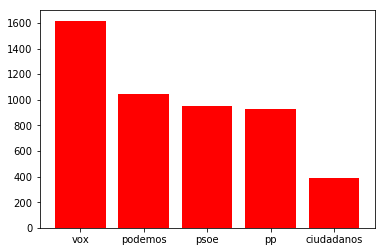

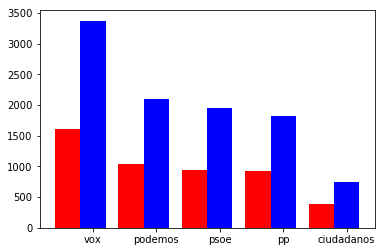

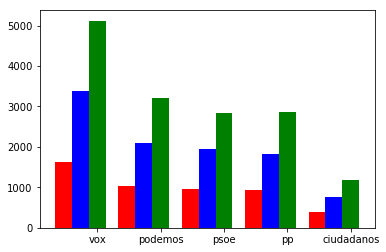

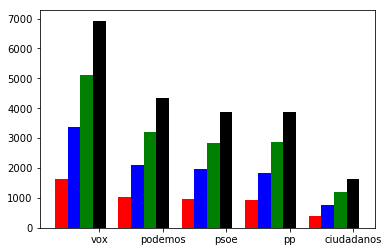

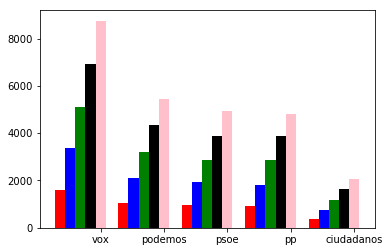

In [44]:

# Diccionario para crear el dataframe.
df_dict = {"candidatos": ['vox', 'podemos', 'psoe', 'pp', 'ciudadanos'], "suma_1": np.zeros(5), "suma_2": np.zeros(5), "suma_3": np.zeros(5), "suma_4": np.zeros(5), "suma_5": np.zeros(5)}

# Definimos dos dataframes vacíos con los candidatos y sus menciones y otro con los hashtags y su conteo.
df_can = pd.DataFrame(df_dict)
df_hashtags_fin = pd.DataFrame({'hashtag': [], 'count': []})

# Rellenamos el dataframe anterior de forma acumulativa en 5 ciclos.
for a in range(5):

    for i in candidatos_lower:

        nombre_tabla = "tabla_pop_" + i[0]

        # Añadimos los valores de True al dataframe creado anteriormente.
        top_pop = sqlContext.sql('Select candidato, count from ' + nombre_tabla)
        tabla = top_pop.toPandas()

        # Nos aseguramos de que exista un valor para añadir, en caso contrario añadimos 0.
        if tabla.shape[0] > 1:
            val = tabla.iloc[np.where(tabla['candidato'] == True)[0], 1]
            val = val[1]
        else:
            val = 0

        # Sumamos a los 0s los valores obtenidos.
        df_can.iloc[np.where(df_can['candidatos'] == i[0])[0], a + 1] += val

        # Necesitamos sumar las nuevas menciones para mostrar el aumento.
        if a > 0:

            df_can.iloc[np.where(df_can['candidatos'] == i[0])[0], a + 1] += df_can.iloc[np.where(df_can['candidatos'] == i[0])[0], a]

        # Hacemos algo similar con los hashtags, hacemos un merge conservando todos los hashtags diferentes
        # y sumando los ya utilizados.
        top_hashtags = sqlContext.sql('Select hashtag, count from tabla_hashtags')
        df_hashtags = top_hashtags.toPandas()

        df_hashtags_fin = df_hashtags_fin.set_index('hashtag').add(df_hashtags.set_index('hashtag'), fill_value=0).reset_index()

    # Mostramos la comparativa de menciones en cada iteración.
    x = df_can['candidatos']
    y = df_can.iloc[:, 1:(a + 2)]

    colores = ['red', 'blue', 'green', 'black', 'pink']
    for o in range(a + 1):

        plt.bar([idx + 0.8*o/(a + 1) for idx in range(len(x))], y.iloc[:, o], color = colores[o], width = 0.8/(a + 1), tick_label = x)
    plt.show()

    # Introducimos un delay igual al tiempo entre ventanas para que se calcule el nuevo batch y tablas derivadas.
    time.sleep(300)


Realizamos los plots finales y los guardamos. También mostramos las tablas obtenidas.

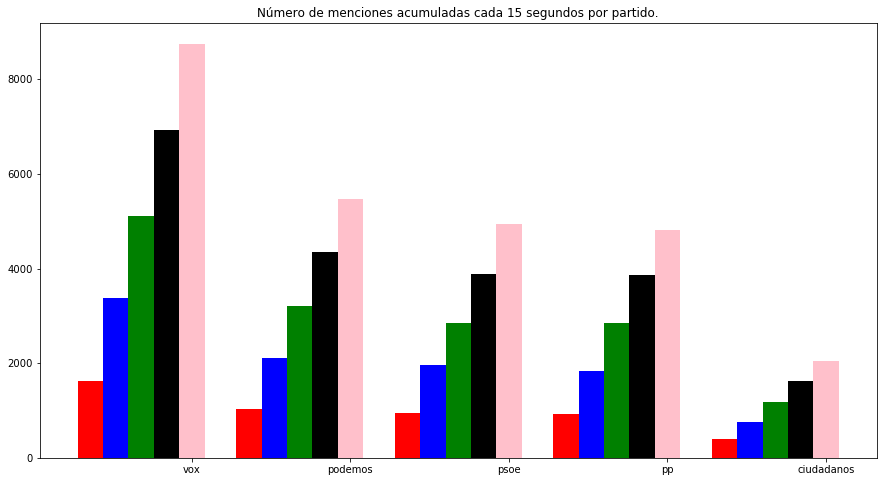

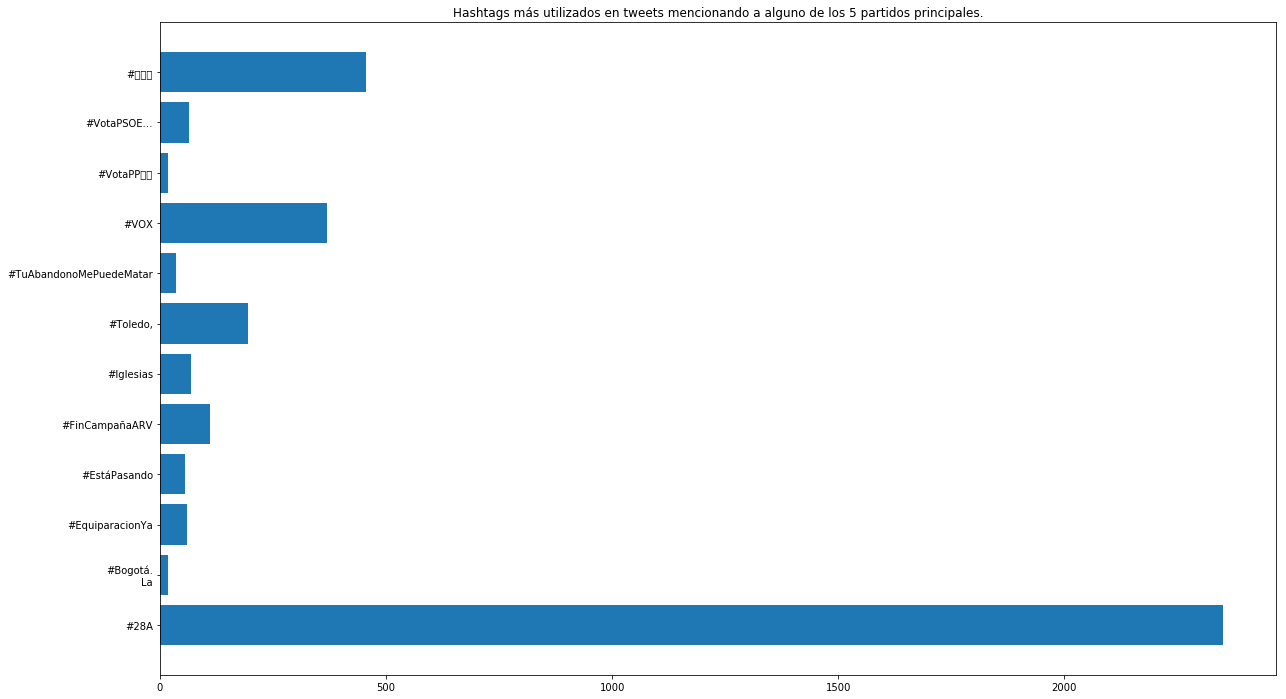

   candidatos  suma_1  suma_2  suma_3  suma_4  suma_5
0         vox  1617.0  3374.0  5120.0  6926.0  8752.0
1     podemos  1041.0  2102.0  3202.0  4346.0  5463.0
2        psoe   949.0  1952.0  2850.0  3885.0  4939.0
3          pp   931.0  1828.0  2858.0  3870.0  4810.0
4  ciudadanos   388.0   751.0  1184.0  1632.0  2046.0


                    hashtag   count
0                      #28A  2350.0
1              #Bogotá.\nLa    18.0
2           #EquiparacionYa    60.0
3              #EstáPasando    55.0
4            #FinCampañaARV   110.0
5                 #Iglesias    68.0
6                  #Toledo,   195.0
7   #TuAbandonoMePuedeMatar    36.0
8                      #VOX   370.0
9                 #VotaPP🇪🇸    18.0
10               #VotaPSOE…    65.0
11                     #草彅剛   455.0


In [47]:

# Plots finales:

# de menciones:
x = df_can['candidatos']
y = df_can.iloc[:, 1:(a + 2)]

colores = ['red', 'blue', 'green', 'black', 'pink']
plt.figure(figsize = (15, 8))
for o in range(a + 1):

    plt.bar([idx + 0.8*o/(a + 1) for idx in range(len(x))], y.iloc[:, o], color = colores[o], width = 0.8/(a + 1), tick_label = x)
plt.title("Número de menciones acumuladas cada 15 segundos por partido.")
plt.savefig('menciones.png')
plt.show()

# de hashtags.
x = df_hashtags_fin['hashtag']
y = df_hashtags_fin.iloc[:, 1]

plt.figure(figsize = (20, 12))
plt.barh([idx for idx in range(len(x))], y, tick_label = x)
plt.title("Hashtags más utilizados en tweets mencionando a alguno de los 5 partidos principales.")
plt.savefig('hashtags.png')
plt.show()

print(df_can)

print("\n")

print(df_hashtags_fin)


Finalizamos deteniendo el streaming.

In [46]:

# Detenemos el streaming.
ssc.stop()

# Limpiamos el puerto utilizado para poder usarlo inmediatamente después.
os.system('kill $(lsof -ti tcp:9992)')
os.system('fuser 9992/tcp')

print(" ")
